In [105]:
from pyspark.sql import SparkSession, functions
from pyspark.sql.functions import col, count, when, regexp_replace, round
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import folium
import pandas as pd
import matplotlib.pyplot as plt

## Etude de cas

In [ ]:
# Session Spark
spark = SparkSession.builder.appName("SegmentationRisqueRoutier").getOrCreate()

In [107]:
caract = spark.read.format('csv').options(header='True', sep=';').load('Data/carcteristiques-2022.csv')
lieux = spark.read.format('csv').options(header='True', sep=';').load('Data/lieux-2022.csv')

In [108]:
lieux.limit(1).show()

+------------+----+--------------------+---+---+----+---+----+----+---+---+----+------+-------+----+-----+----+---+
|     Num_Acc|catr|                voie| v1| v2|circ|nbv|vosp|prof| pr|pr1|plan|lartpc|larrout|surf|infra|situ|vma|
+------------+----+--------------------+---+---+----+---+----+----+---+---+----+------+-------+----+-----+----+---+
|202200000001|   4|TEIL(vieille rout...|  0|N/A|   2|  2|   0|   1|(1)|(1)|   1|  NULL|     -1|   1|    0|   1| 50|
+------------+----+--------------------+---+---+----+---+----+----+---+---+----+------+-------+----+-----+----+---+



In [109]:
caract.limit(1).show()

+------------+----+----+----+-----+---+---+-----+---+---+---+---+--------------------+-------------+------------+
| Accident_Id|jour|mois|  an| hrmn|lum|dep|  com|agg|int|atm|col|                 adr|          lat|        long|
+------------+----+----+----+-----+---+---+-----+---+---+---+---+--------------------+-------------+------------+
|202200000001|  19|  10|2022|16:15|  1| 26|26198|  2|  3|  1|  3|TEIL(vieille rout...|44,5594200000|4,7257200000|
+------------+----+----+----+-----+---+---+-----+---+---+---+---+--------------------+-------------+------------+



In [ ]:
Accident_caract = caract.selectExpr(
    "`Accident_Id` AS `ID`",
    "`dep` AS `Departement`",
    "`com` AS `Code_Postal`",
    "`lat` AS `GPS1`",
    "`long` AS `GPS2`",
    "`int` AS `Intersection`",
    "`atm` AS `Metéologie`",
    "`col` AS `type_colision`"
)

Accident_lieu = lieux.selectExpr(
    "`Num_Acc` AS `ID`",
    "`catr` AS `Type_Route`",
    "`voie` AS `Voie`",
    "`surf` AS `Etat_Surface`"
)

In [ ]:
Accident_caract.limit(20).show()


+------------+-----------+-----------+-------------+--------------+------------+----------+-------------+
|          ID|Departement|Code_Postal|         GPS1|          GPS2|Intersection|Metéologie|type_colision|
+------------+-----------+-----------+-------------+--------------+------------+----------+-------------+
|202200000001|         26|      26198|44,5594200000|  4,7257200000|           3|         1|            3|
|202200000002|         25|      25204|46,9258100000|  6,3462000000|           3|         1|            3|
|202200000003|         22|      22360|48,4931620000| -2,7604390000|           6|         1|            2|
|202200000004|         16|      16102|45,6926520000| -0,3262900000|           3|         8|            6|
|202200000005|         13|      13103|43,6755790366|  5,0927031775|           1|         1|            2|
|202200000006|         13|      13056|43,4127500000|  5,0505900000|           2|         1|            3|
|202200000007|         13|      13063|43,58229

In [112]:
Accident_lieu.limit(20).show()

+------------+----------+--------------------+------------+
|          ID|Type_Route|                Voie|Etat_Surface|
+------------+----------+--------------------+------------+
|202200000001|         4|TEIL(vieille rout...|           1|
|202200000002|         4|                 N/A|           1|
|202200000003|         3|ROND POINT DE BRE...|           1|
|202200000004|         4|QUATORZE JUILLET ...|           1|
|202200000005|         3|ROUTE DE JEAN MOU...|           1|
|202200000006|         3|      TURCAN FRANCIS|           1|
|202200000007|         4|         CARNOT  RUE|           1|
|202200000008|         4|JAURES JEAN (AVENUE)|           1|
|202200000009|         4|   LOMBARDS (AVENUE)|           2|
|202200000010|         4|PREMIER MAI (RUE DU)|           1|
|202200000011|         3|  ESPAGNE (ROUTE D')|           2|
|202200000012|         4|    CASSIN (BD RENE)|           1|
|202200000013|         3| GRIVATS (ROUTE DES)|           1|
|202200000014|         4|          GRAND

In [113]:
Accident_lieu.count()

55302

In [ ]:
# Jointure des df
df_accident = Accident_caract.join(Accident_lieu, ['ID'], 'inner')

In [115]:
# Vérification des valeurs manquantes
df_accident.select([count(when(col(c).isNull(), c)).alias(c) for c in df_accident.columns]).show()

+---+-----------+-----------+----+----+------------+----------+-------------+----------+----+------------+
| ID|Departement|Code_Postal|GPS1|GPS2|Intersection|Metéologie|type_colision|Type_Route|Voie|Etat_Surface|
+---+-----------+-----------+----+----+------------+----------+-------------+----------+----+------------+
|  0|          0|          0|   0|   0|           0|         0|            0|         0|   0|           0|
+---+-----------+-----------+----+----+------------+----------+-------------+----------+----+------------+



In [ ]:
df_accident = df_accident.withColumn("GPS1", regexp_replace(col("GPS1"), ",", "."))
df_accident = df_accident.withColumn("GPS2", regexp_replace(col("GPS2"), ",", "."))

In [ ]:
df_accident = df_accident.withColumn("GPS1", col("GPS1").cast("double"))
df_accident = df_accident.withColumn("GPS2", col("GPS2").cast("double"))

In [ ]:
vector_assembler = VectorAssembler(inputCols=["GPS1", "GPS2"], outputCol="features")
accidents_features_df = vector_assembler.transform(df_accident)

In [119]:
kmeans = KMeans(k=20, seed=123, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(accidents_features_df)
clustered_accidents = model.transform(accidents_features_df)

In [120]:
accident_clusters_count = clustered_accidents.groupBy("cluster").agg(functions.count("*").alias("accident_count"))

In [121]:
total_accidents = accident_clusters_count.agg(functions.sum("accident_count").alias("total")).collect()[0]["total"]

In [122]:
accident_clusters_count_with_pct = accident_clusters_count.withColumn(
    "accident_pct",
    round((col("accident_count") / total_accidents) * 100, 2)
)

In [123]:
accident_clusters_count_with_pct.orderBy(functions.desc("accident_count")).show()

+-------+--------------+------------+
|cluster|accident_count|accident_pct|
+-------+--------------+------------+
|      9|         18699|       33.81|
|     15|          6683|       12.08|
|      6|          3827|        6.92|
|     17|          3520|        6.37|
|     11|          3334|        6.03|
|     13|          2950|        5.33|
|     14|          2721|        4.92|
|      0|          2648|        4.79|
|      7|          2138|        3.87|
|     19|          1844|        3.33|
|     18|          1711|        3.09|
|      8|          1697|        3.07|
|      2|           981|        1.77|
|     10|           748|        1.35|
|     16|           608|         1.1|
|      5|           558|        1.01|
|      4|           255|        0.46|
|      3|           192|        0.35|
|      1|           174|        0.31|
|     12|            14|        0.03|
+-------+--------------+------------+



In [124]:
# Calculer le centroïde pour chaque cluster
cluster_centroids = clustered_accidents.groupBy("cluster").agg(
    functions.avg("GPS1").alias("avg_latitude"),
    functions.avg("GPS2").alias("avg_longitude"),
    functions.count("*").alias("accident_count")
)

In [125]:
cluster_centroids_pd = cluster_centroids.toPandas()

In [126]:
m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)

In [ ]:
# Ajouter des marqueurs pour chaque cluster
for i, row in cluster_centroids_pd.iterrows():
    accident_count = float(row['accident_count'])
    
    if accident_count / 1000 < 5:
        radius = 5 
    else:
        radius = accident_count / 1000
    
    folium.CircleMarker(
        location=[row['avg_latitude'], row['avg_longitude']],
        radius=radius,
        popup=f"Cluster: {row['cluster']}<br>Accidents: {accident_count}",
        color="blue",
        fill=True,
        fill_color="blue"
    ).add_to(m)

# Sauvegarde
m.save("Result/accident_clusters_map.html")

In [128]:
cluster_centroids_pd = cluster_centroids_pd.sort_values(by="accident_count", ascending=False)

In [129]:
nombre_total_clusters = cluster_centroids_pd.shape[0]
seuil_niveau_1 = nombre_total_clusters // 3
seuil_niveau_2 = 2 * nombre_total_clusters // 3

In [ ]:
def assigner_tier_list(index):
    if index < seuil_niveau_1:
        return "Tier 1 (Moins dangereux)"
    elif index < seuil_niveau_2:
        return "Tier 2 (Danger moyen)"
    else:
        return "Tier 3 (Plus dangereux)"

In [131]:
cluster_centroids_pd["tier"] = cluster_centroids_pd.index.to_series().apply(assigner_tier_list)

In [132]:
print(cluster_centroids_pd[["cluster", "accident_count", "tier"]])

    cluster  accident_count                      tier
9         9           18699     Tier 2 (Danger moyen)
8        15            6683     Tier 2 (Danger moyen)
3         6            3827  Tier 1 (Moins dangereux)
10       17            3520     Tier 2 (Danger moyen)
15       11            3334   Tier 3 (Plus dangereux)
2        13            2950  Tier 1 (Moins dangereux)
16       14            2721   Tier 3 (Plus dangereux)
18        0            2648   Tier 3 (Plus dangereux)
13        7            2138   Tier 3 (Plus dangereux)
7        19            1844     Tier 2 (Danger moyen)
19       18            1711   Tier 3 (Plus dangereux)
12        8            1697     Tier 2 (Danger moyen)
17        2             981   Tier 3 (Plus dangereux)
14       10             748   Tier 3 (Plus dangereux)
4        16             608  Tier 1 (Moins dangereux)
6         5             558     Tier 2 (Danger moyen)
11        4             255     Tier 2 (Danger moyen)
5         3             192 

In [133]:
cluster_centroids_pd.to_csv("Result/accident_clusters_tier_list.csv", index=False)

On peut voir que la majorité des accidents se situent dans la région parisienne et dans la plupart des grandes villes. On peut analyser ces accidents pour en soutirer des causes.

## Analyse

In [134]:
# Agréger le nombre d’accidents par type de route
accidents_par_route = df_accident.groupBy("Type_Route").agg(functions.count("*").alias("Nombre_Accidents"))
accidents_par_atm = df_accident.groupBy("Metéologie").agg(functions.count("*").alias("Nombre_Accidents"))
accidents_par_surface = df_accident.groupBy("Etat_Surface").agg(functions.count("*").alias("Nombre_Accidents"))


In [135]:
accidents_par_route_pd = accidents_par_route.toPandas()
accidents_par_atm_pd = accidents_par_atm.toPandas()
accidents_par_surface_pd = accidents_par_surface.toPandas()


In [136]:
route_labels = {
    "1": "Autoroute",
    "2": "Route Nationale",
    "3": "Route Départementale",
    "4": "Voie Communale",
    "5": "Hors Réseau Public",
    "6": "Parc de stationnement",
    "7": "Routes de métropole",
    "9": "Autres"
}

In [137]:
accidents_par_route_pd["Type_Route"] = accidents_par_route_pd["Type_Route"].map(route_labels)

In [138]:
accidents_par_route_pd = accidents_par_route_pd.sort_values(by="Nombre_Accidents", ascending=False)

In [139]:
mapping_expr = functions.create_map(
    [functions.lit(x) for x in sum(route_labels.items(), ())]
)

accidents_par_route_named = accidents_par_route.withColumn(
    "Type_Route_Nom",
    mapping_expr[col("Type_Route")]
)

In [140]:
total_accidents = accidents_par_route_named.agg(functions.sum("Nombre_Accidents").alias("total")).collect()[0]["total"]

accidents_par_route_with_pct = accidents_par_route_named.withColumn(
    "Pourcentage",
    round((col("Nombre_Accidents") / total_accidents) * 100, 2)
)

In [141]:
accidents_par_route_with_pct.orderBy(functions.desc("Pourcentage")).select(
    "Type_Route", "Type_Route_Nom", "Nombre_Accidents", "Pourcentage"
).show()

+----------+--------------------+----------------+-----------+
|Type_Route|      Type_Route_Nom|Nombre_Accidents|Pourcentage|
+----------+--------------------+----------------+-----------+
|         4|      Voie Communale|           22671|      40.99|
|         3|Route Départementale|           21162|      38.27|
|         1|           Autoroute|            5083|       9.19|
|         2|     Route Nationale|            3584|       6.48|
|         7| Routes de métropole|            2090|       3.78|
|         6|Parc de stationne...|             394|       0.71|
|         9|              Autres|             262|       0.47|
|         5|  Hors Réseau Public|              56|        0.1|
+----------+--------------------+----------------+-----------+



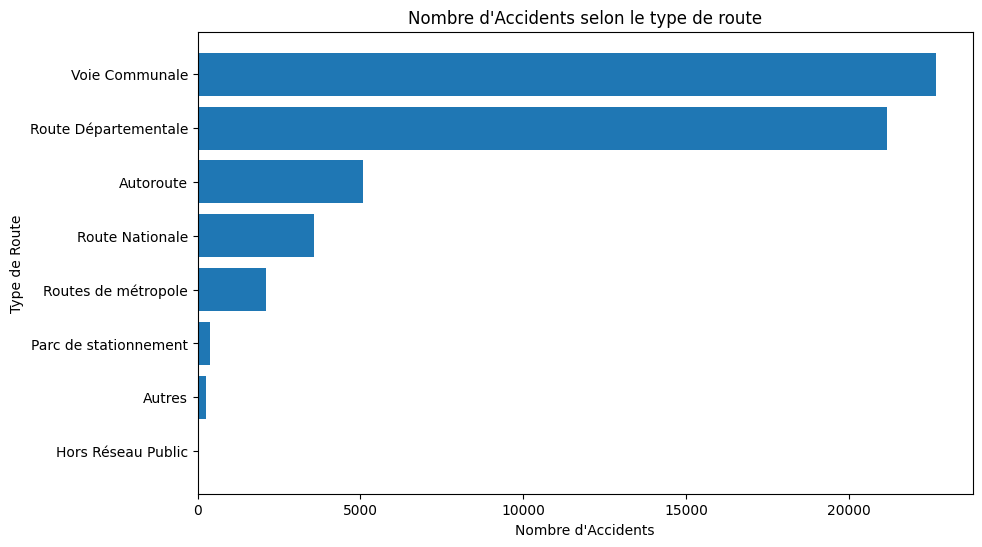

In [142]:
plt.figure(figsize=(10, 6))
plt.barh(accidents_par_route_pd["Type_Route"], accidents_par_route_pd["Nombre_Accidents"])
plt.xlabel("Nombre d'Accidents")
plt.ylabel("Type de Route")
plt.title("Nombre d'Accidents selon le type de route")
plt.gca().invert_yaxis()
plt.show()

Les voies communales et départementales sont moins sécurisées. L’autoroute et les nationales, malgré des vitesses élevées, ce qui paraît toutefois normal.

In [143]:
atm_labels = {
    "1": "Normale",
    "2": "Pluie légère",
    "3": "Pluie forte",
    "4": "Neige - grêle",
    "5": "Brouillard - fumée",
    "6": "Vent fort - tempête",
    "7": "Temps éblouissant",
    "8": "Temps couvert",
    "9": "Autre"
}

surf_labels = {
    "1": "Normale",
    "2": "Mouillée",
    "3": "Flaques",
    "4": "Inondée",
    "5": "Enneigée",
    "6": "Boue",
    "7": "Verglacée",
    "8": "Corps gras – huile",
    "9": "Autre"
}

In [144]:
# accidents_par_atm_pd["Metéologie"] = accidents_par_atm_pd["Metéologie"].astype(str)
# accidents_par_surface_pd["Etat_Surface"] = accidents_par_surface_pd["Etat_Surface"].astype(str)


In [145]:
accidents_par_atm_pd["Conditions atmosphériques"] = accidents_par_atm_pd["Metéologie"].map(atm_labels)
accidents_par_surface_pd["Etat de la surface"] = accidents_par_surface_pd["Etat_Surface"].map(surf_labels)

In [146]:
accidents_par_atm_pd.dtypes

Metéologie                   object
Nombre_Accidents              int64
Conditions atmosphériques    object
dtype: object

In [147]:
accidents_par_surface_pd.dtypes

Etat_Surface          object
Nombre_Accidents       int64
Etat de la surface    object
dtype: object

In [148]:
accidents_par_atm_pd["Conditions atmosphériques"] = accidents_par_atm_pd["Conditions atmosphériques"].astype(str)
accidents_par_surface_pd["Etat de la surface"] = accidents_par_surface_pd["Etat de la surface"].astype(str)


In [ ]:
# Trier par du plus au moins accidentogènes
accidents_par_atm_pd = accidents_par_atm_pd.sort_values(by="Nombre_Accidents", ascending=False)
accidents_par_surface_pd = accidents_par_surface_pd.sort_values(by="Nombre_Accidents", ascending=False)

In [150]:
accidents_par_atm_pd

,Metéologie,Nombre_Accidents,Conditions atmosphériques
6,1,45269,Normale
9,2,4934,Pluie légère
2,8,1927,Temps couvert
0,7,1143,Temps éblouissant
1,3,981,Pluie forte
3,5,531,Brouillard - fumée
5,9,263,Autre
8,4,130,Neige - grêle
4,6,123,Vent fort - tempête
7,-1,1,nan


In [151]:
accidents_par_surface_pd

,Etat_Surface,Nombre_Accidents,Etat de la surface
7,1,46025,Normale
10,2,8429,Mouillée
6,9,331,Autre
0,7,218,Verglacée
1,3,88,Flaques
2,8,87,Corps gras – huile
4,5,51,Enneigée
5,6,37,Boue
9,4,26,Inondée
8,-1,9,nan


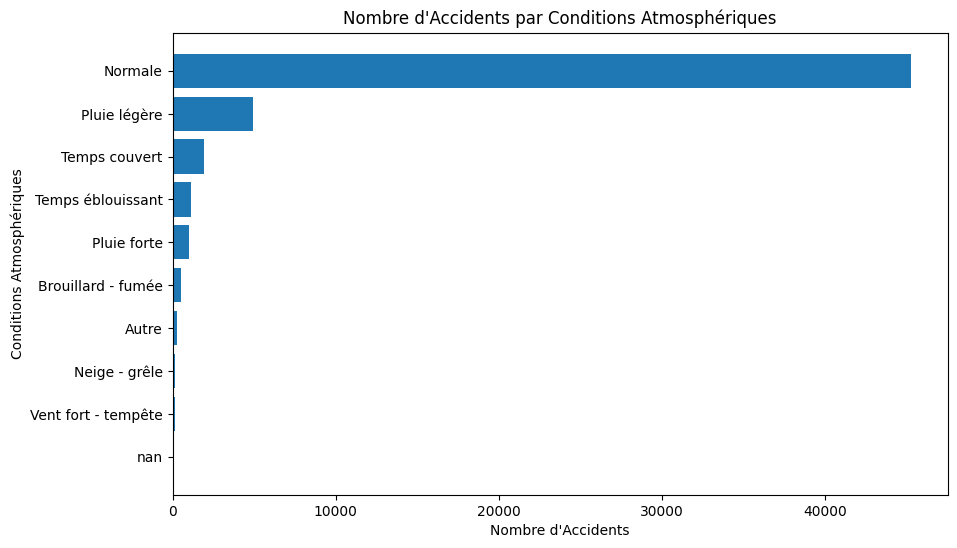

In [152]:
plt.figure(figsize=(10, 6))
plt.barh(accidents_par_atm_pd["Conditions atmosphériques"], accidents_par_atm_pd["Nombre_Accidents"])
plt.xlabel("Nombre d'Accidents")
plt.ylabel("Conditions Atmosphériques")
plt.title("Nombre d'Accidents par Conditions Atmosphériques")
plt.gca().invert_yaxis()
plt.show()

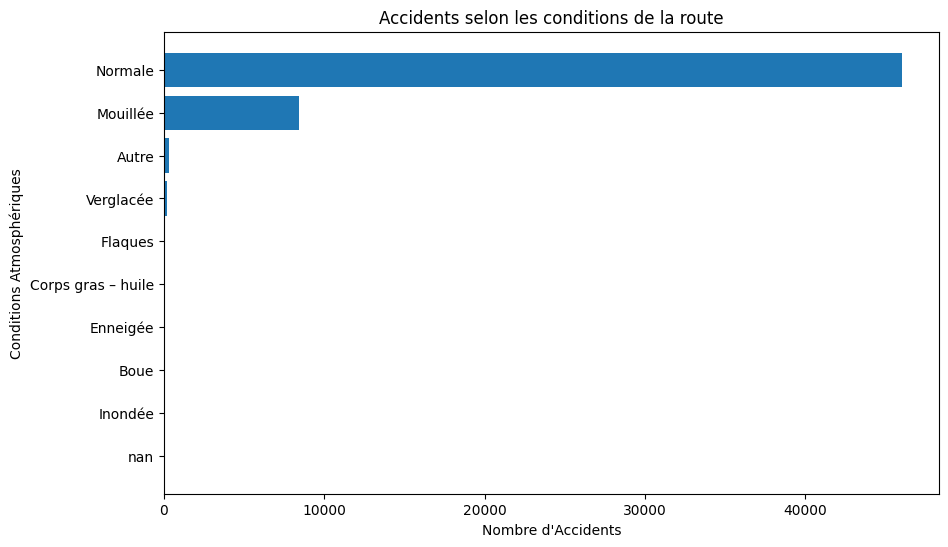

In [153]:
# 📊 Visualisation
plt.figure(figsize=(10, 6))
plt.barh(accidents_par_surface_pd["Etat de la surface"], accidents_par_surface_pd["Nombre_Accidents"])
plt.xlabel("Nombre d'Accidents")
plt.ylabel("Conditions Atmosphériques")
plt.title("Accidents selon les conditions de la route")
plt.gca().invert_yaxis()
plt.show()

Regardons pour terminer quel type de colisions qu'on retrouve le plus souvent

In [154]:
accidents_par_collision = df_accident.groupBy("type_colision").agg(functions.count("*").alias("Nombre_Accidents"))

accidents_par_collision_pd = accidents_par_collision.toPandas()

collision_labels = {
    "-1": "Non renseigné",
    "1": "Deux véhicules - frontale",
    "2": "Deux véhicules – par l’arrière",
    "3": "Deux véhicules – par le côté",
    "4": "Trois véhicules et plus – en chaîne",
    "5": "Trois véhicules et plus - collisions multiples",
    "6": "Autre collision",
    "7": "Sans collision"
}

accidents_par_collision_pd["type_colision"] = accidents_par_collision_pd["type_colision"].map(collision_labels)

In [155]:
accidents_par_collision_pd["type_colision"] = accidents_par_collision_pd["type_colision"].astype(str)

accidents_par_collision_pd = accidents_par_collision_pd.sort_values(by="Nombre_Accidents", ascending=False)

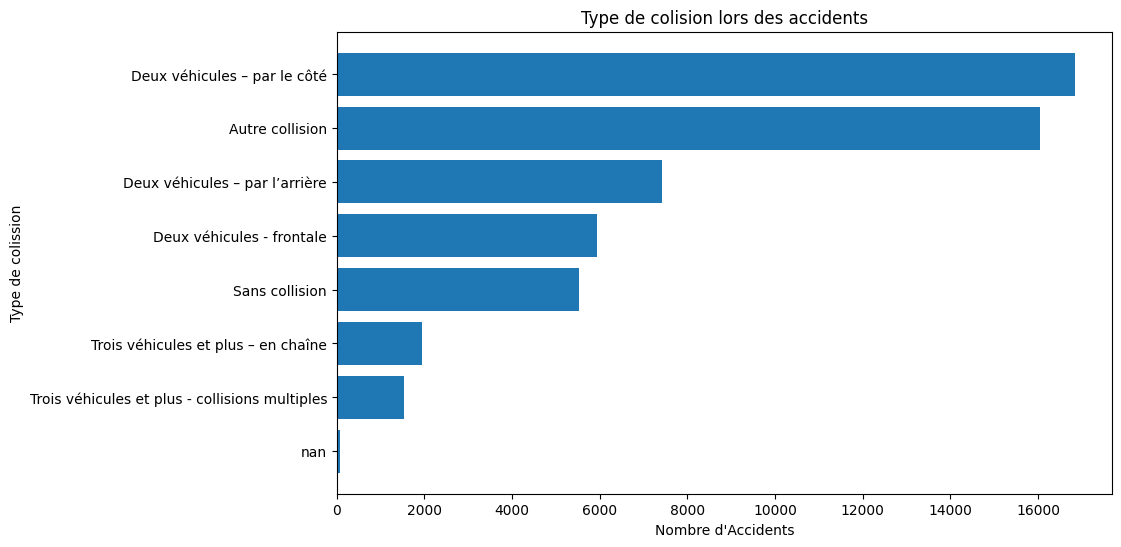

In [156]:
plt.figure(figsize=(10, 6))
plt.barh(accidents_par_collision_pd["type_colision"], accidents_par_collision_pd["Nombre_Accidents"])
plt.xlabel("Nombre d'Accidents")
plt.ylabel("Type de colission")
plt.title("Type de colision lors des accidents")
plt.gca().invert_yaxis()
plt.show()

## Conclusion

Une route communale est la plus accidentogène, car l'excès de confiance et le manque d’anticipation semblent être les principales causes des accidents en conditions normales.